# 01 · Exploratorio de Imágenes y Detectores (SIFT / ORB / AKAZE)
**Objetivo:** cargar imágenes reales (≥3), visualizarlas y comparar detectores/descritores en:
- Número de *keypoints* por imagen
- Tiempo total de detección+descripción
- Calidad inicial del *matching* (0–1, 0–2) con regla de Lowe y *inliers* por RANSAC

In [9]:
import os

# Ir al root del repo (sube un nivel desde /notebooks)
if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")

import glob, time
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from src.feature_detection import detect_and_describe
from src.matching import match_descriptors
from src.registration import estimate_homography
from src.utils import imread_color

plt.rcParams['figure.figsize'] = (10, 7)
plt.rcParams['axes.grid'] = True

DATA_DIR = "data/original"
FIG_DIR = "results/figures"
os.makedirs(FIG_DIR, exist_ok=True)

## 1) Carga de imágenes

In [2]:
paths = sorted(glob.glob(os.path.join(DATA_DIR, '*')))
print("Encontradas:", len(paths), "imágenes")
assert len(paths) >= 2, "Coloca al menos 2 imágenes en data/original/"

imgs_all = [imread_color(p) for p in paths]
for i, (p, im) in enumerate(zip(paths, imgs_all)):
    print(f"[{i}] {os.path.basename(p)} -> shape={im.shape}")
sel_idx = list(range(min(3, len(imgs_all))))
imgs = [imgs_all[i] for i in sel_idx]

Encontradas: 3 imágenes
[0] IMG01.jpg -> shape=(4032, 3024, 3)
[1] IMG02.jpg -> shape=(4032, 3024, 3)
[2] IMG03.jpg -> shape=(3024, 4032, 3)


## 2) Vista previa

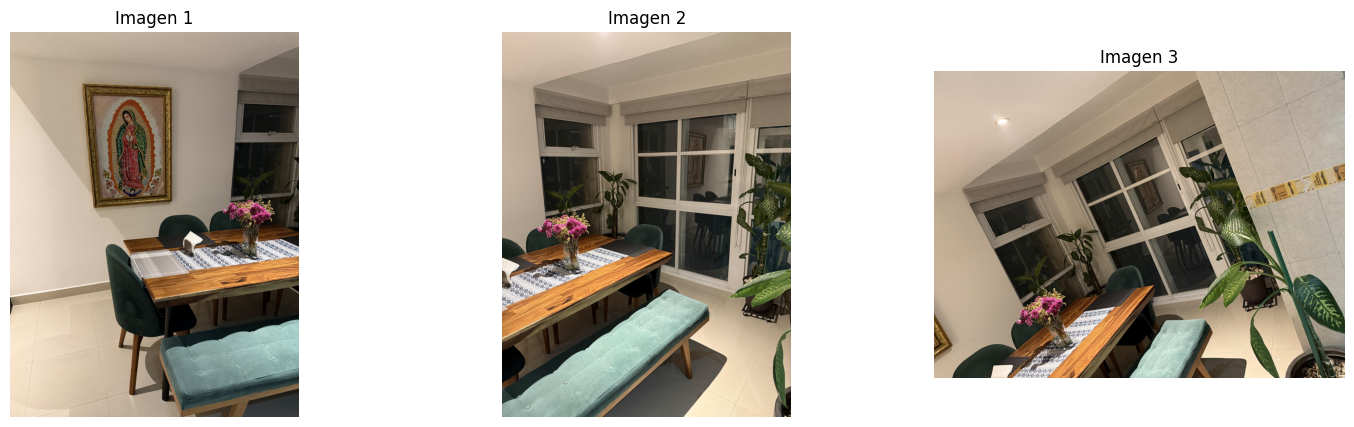

In [3]:
cols = len(imgs)
fig, axes = plt.subplots(1, cols, figsize=(6*cols, 5))
if cols == 1:
    axes = [axes]
for ax, im, i in zip(axes, imgs, range(cols)):
    ax.imshow(cv.cvtColor(im, cv.COLOR_BGR2RGB))
    ax.set_title(f"Imagen {i+1}")
    ax.axis('off')
plt.show()

## 3) Detección y descripción

In [4]:
detectors = ["SIFT", "ORB", "AKAZE"]

def run_detector(images, method):
    stats = []
    kps, descs = [], []
    t0 = time.time()
    for im in images:
        k, d = detect_and_describe(im, method=method)
        kps.append(k); descs.append(d)
        stats.append((len(k), d.shape if d is not None else None))
    return {
        "keypoints_per_image": [s[0] for s in stats],
        "descriptors_shapes": [s[1] for s in stats],
        "total_time_sec": time.time() - t0
    }, kps, descs

summary = {}
kp_store, desc_store = {}, {}
for m in detectors:
    s, kps, descs = run_detector(imgs, m)
    summary[m] = s
    kp_store[m] = kps
    desc_store[m] = descs

pd.DataFrame([{
    "detector": m,
    "tiempo_total_s": round(summary[m]["total_time_sec"], 3),
    **{f"kp_img{i}": n for i, n in enumerate(summary[m]["keypoints_per_image"])}
} for m in detectors]).set_index("detector")

tiempo_total_s  kp_img0  kp_img1  kp_img2
detector                                           
SIFT               6.601    61930    37273    33332
ORB                0.617     3000     3000     3000
AKAZE              4.553    18397    18175    18781

## 4) Matching entre pares y *inliers*

In [5]:
pair_indices = [(0,1)]
if len(imgs) >= 3:
    pair_indices.append((0,2))

def evaluate_pair(i, j, method, ratio=0.75):
    kpi, desi = kp_store[method][i], desc_store[method][i]
    kpj, desj = kp_store[method][j], desc_store[method][j]
    strategy = "FLANN" if method=="SIFT" else "BF"
    t0 = time.time()
    matches = match_descriptors(desi, desj, strategy=strategy, ratio=ratio)
    t_match = time.time() - t0
    inliers = None
    if len(matches) >= 4:
        try:
            H, mask = estimate_homography(kpi, kpj, matches, ransac_thresh=3.0)
            inliers = int(mask.sum())
        except Exception:
            pass
    return len(matches), inliers, t_match

rows = []
for (i, j) in pair_indices:
    for m in detectors:
        nmatch, inl, dt = evaluate_pair(i, j, m)
        rows.append({"par": f"{i}-{j}", "detector": m, "matches": nmatch, "inliers": inl, "t_match_s": round(dt,3)})
pd.DataFrame(rows)

par detector  matches  inliers  t_match_s
0  0-1     SIFT     6026     3617      2.877
1  0-1      ORB      681      422      0.025
2  0-1    AKAZE     3593     1810      1.101
3  0-2     SIFT     3317     1683      2.824
4  0-2      ORB      304      165      0.025
5  0-2    AKAZE     2073      986      1.134

## 5) Vista de *matches* (par 0–1)

Guardado: results/figures\matches_inliers_SIFT_0-1.png
Guardado: results/figures\matches_inliers_ORB_0-1.png
Guardado: results/figures\matches_inliers_AKAZE_0-1.png


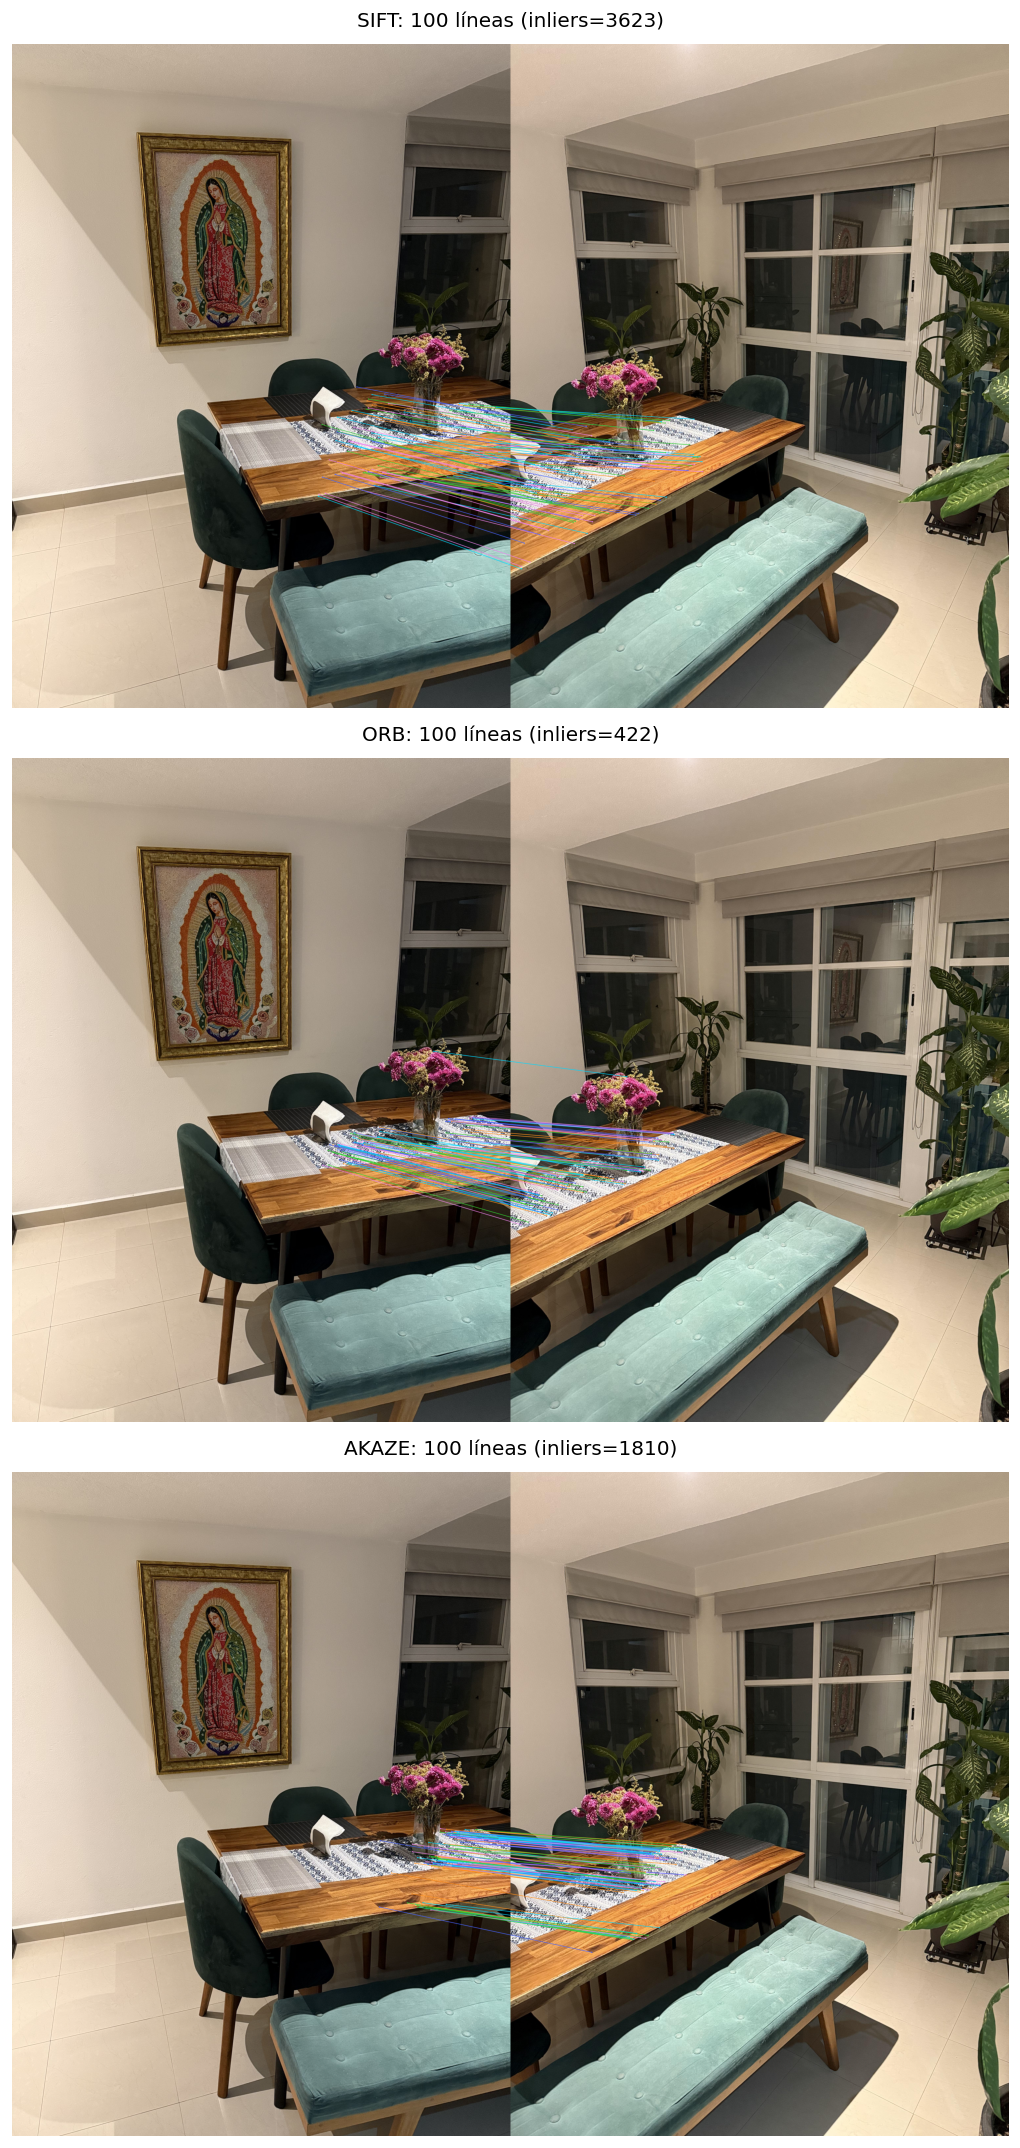

In [11]:
i, j = pair_indices[0]
TOP_K = 100         # nº de líneas visibles
THICK = 2          # grosor de línea
RATIO = 0.75

def render_matches_custom(img1, img2, kp1, kp2, matches, mask=None, max_draw=40, thick=2):
    # lienzo lado a lado con margen
    h = max(img1.shape[0], img2.shape[0])
    w = img1.shape[1] + img2.shape[1]
    canvas = np.zeros((h, w, 3), dtype=np.uint8)
    canvas[:img1.shape[0], :img1.shape[1]] = img1
    canvas[:img2.shape[0], img1.shape[1]:] = img2

    # elegir solo inliers (si hay mask)
    if mask is not None:
        inlier_matches = [m for m, keep in zip(matches, mask.ravel().tolist()) if keep]
    else:
        inlier_matches = matches

    # ordena por distancia y limita
    inlier_matches = sorted(inlier_matches, key=lambda m: m.distance)[:max_draw]

    colors = [(255, 99, 71), (30, 144, 255), (50, 205, 50), (238, 130, 238), (255, 215, 0)]
    for idx, m in enumerate(inlier_matches):
        c = colors[idx % len(colors)]
        x1, y1 = map(int, kp1[m.queryIdx].pt)
        x2, y2 = map(int, kp2[m.trainIdx].pt)
        x2 += img1.shape[1]

        # puntos
        cv.circle(canvas, (x1, y1), 3, c, -1, lineType=cv.LINE_AA)
        cv.circle(canvas, (x2, y2), 3, c, -1, lineType=cv.LINE_AA)
        # línea
        cv.line(canvas, (x1, y1), (x2, y2), c, thick, lineType=cv.LINE_AA)

    return canvas, len(inlier_matches)

fig, axes = plt.subplots(3, 1, figsize=(10, 18), dpi=120)
FIG_DIR = "results/figures"
os.makedirs(FIG_DIR, exist_ok=True)

for ax, m in zip(axes, detectors):
    kpi, desi = kp_store[m][i], desc_store[m][i]
    kpj, desj = kp_store[m][j], desc_store[m][j]
    strategy = "FLANN" if m == "SIFT" else "BF"
    matches = match_descriptors(desi, desj, strategy=strategy, ratio=RATIO)

    # estimar H y usar inliers para visualizar
    H, mask = None, None
    if len(matches) >= 4:
        try:
            H, mask = estimate_homography(kpi, kpj, matches, ransac_thresh=3.0)
        except Exception:
            pass

    vis, used = render_matches_custom(
        imgs[i], imgs[j], kpi, kpj, matches, mask=mask,
        max_draw=TOP_K, thick=THICK
    )
    ax.imshow(cv.cvtColor(vis, cv.COLOR_BGR2RGB))
    ninl = int(mask.sum()) if mask is not None else None
    ax.set_title(f"{m}: {used} líneas (inliers={ninl})", pad=10)
    ax.axis('off')

    out_path = os.path.join(FIG_DIR, f"matches_inliers_{m}_{i}-{j}.png")
    cv.imwrite(out_path, vis[:, :, ::-1])
    print("Guardado:", out_path)

plt.tight_layout()
plt.show()
